In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from tflcg.layout_guidance_pipeline import LayoutGuidanceStableDiffusionPipeline
from diffusers import EulerDiscreteScheduler, LMSDiscreteScheduler
import torch
seed = 33

pipe = LayoutGuidanceStableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("mps")
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
generator = torch.Generator(device="mps").manual_seed(seed)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

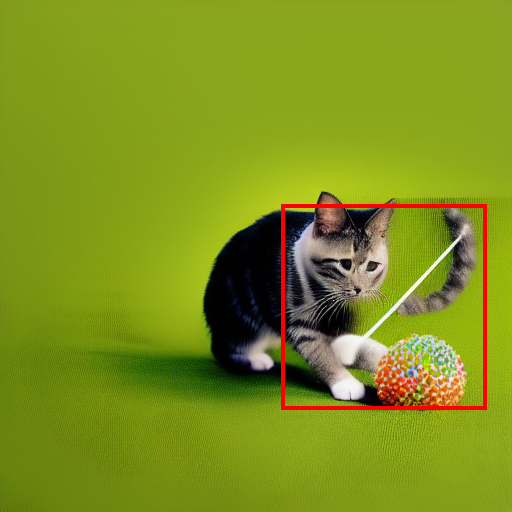

In [11]:
prompt = "A cat playing with a ball"
bboxes = [[0.55, 0.4, 0.95, 0.8]]
image = pipe(prompt, num_inference_steps=20,
             token_indices=[[2]],
             # generator=generator,
             bboxes=bboxes).images[0]
image = pipe.draw_box(image, bboxes)
display(image)

  0%|          | 0/20 [00:00<?, ?it/s]

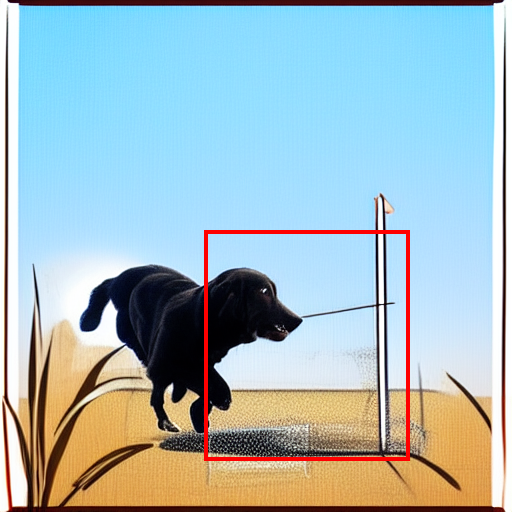

In [12]:
prompt = "A dog chasing its tail"
bboxes = [[0.4, 0.45, 0.8, 0.9]]
image = pipe(prompt, num_inference_steps=20,
             token_indices=[[2]],
             bboxes=bboxes).images[0]
image = pipe.draw_box(image, bboxes)
display(image)

  0%|          | 0/20 [00:00<?, ?it/s]

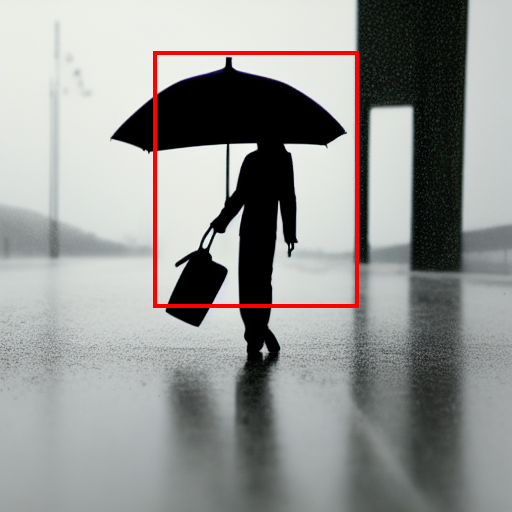

In [13]:
prompt = "A person holding an umbrella in the rain"
bboxes = [[0.3, 0.1, 0.7, 0.6]]
image = pipe(prompt, num_inference_steps=20,
             token_indices=[[4]],
             bboxes=bboxes).images[0]
image = pipe.draw_box(image, bboxes)
display(image)

  0%|          | 0/20 [00:00<?, ?it/s]

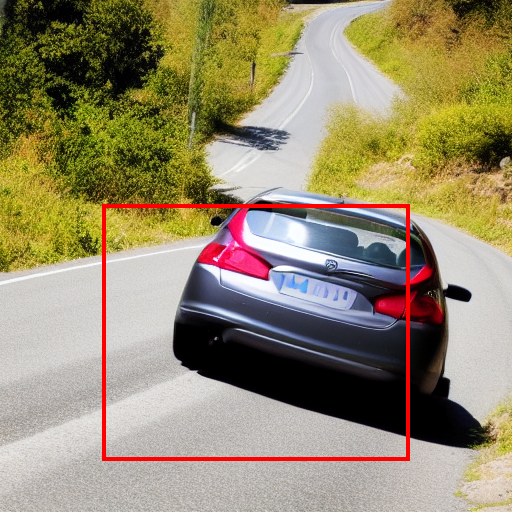

In [14]:
prompt = "A car driving on a winding road"
bboxes = [[0.2, 0.4, 0.8, 0.9]]
image = pipe(prompt, num_inference_steps=20,
             token_indices=[[2]],
             bboxes=bboxes).images[0]
image = pipe.draw_box(image, bboxes)
display(image)

  0%|          | 0/20 [00:00<?, ?it/s]

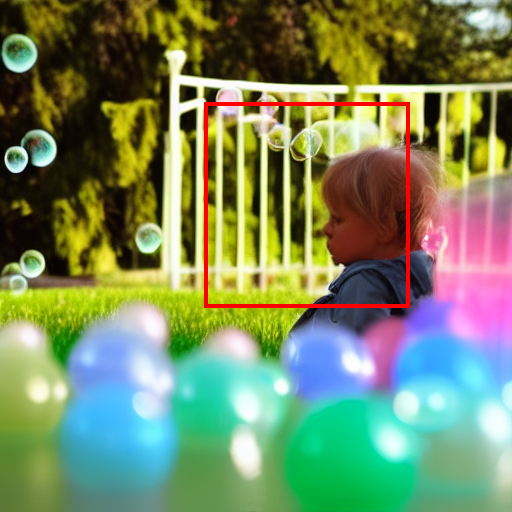

In [15]:
prompt = "A child blowing bubbles"
bboxes = [[0.4, 0.2, 0.8, 0.6]]
image = pipe(prompt, num_inference_steps=20,
             token_indices=[[2]],
             bboxes=bboxes).images[0]
image = pipe.draw_box(image, bboxes)
display(image)

  0%|          | 0/20 [00:00<?, ?it/s]

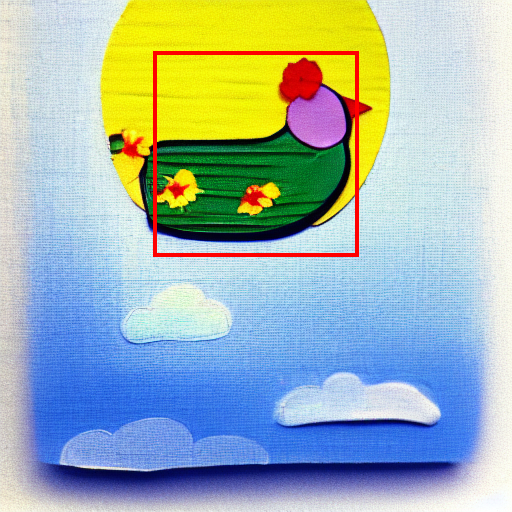

In [16]:
prompt = "A bird flying in the sky"
bboxes = [[0.3, 0.1, 0.7, 0.5]]
image = pipe(prompt, num_inference_steps=20,
             token_indices=[[2]],
             bboxes=bboxes).images[0]
image = pipe.draw_box(image, bboxes)
display(image)

  0%|          | 0/20 [00:00<?, ?it/s]

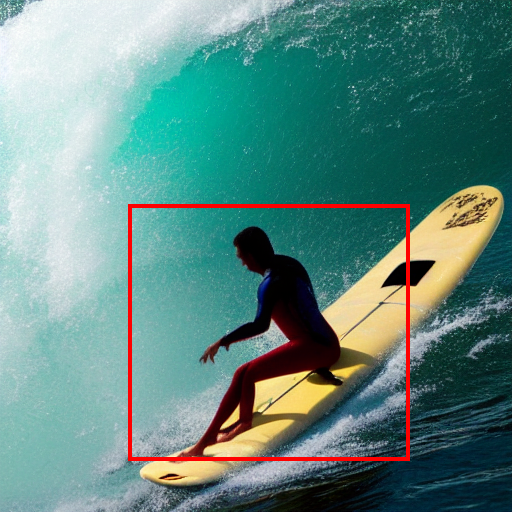

In [17]:
prompt = "A person surfing on a wave"
bboxes = [[0.25, 0.4, 0.8, 0.9]]
image = pipe(prompt, num_inference_steps=20,
             token_indices=[[2]],
             bboxes=bboxes).images[0]
image = pipe.draw_box(image, bboxes)
display(image)